In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_final = pd.read_csv('data\COVID-19-final.csv', ';')
df_final.head()

,code,country,gdp,hdi,uhc,pop_0_14,pop_15_64,pop_65+,week,prev_cases,prev_deaths,cases,deaths
0,AFG,Afghanistan,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,1,0.000000,0.0,0.002629,0.000000
1,AFG,Afghanistan,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,2,0.002629,0.0,0.010515,0.000000
2,AFG,Afghanistan,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,3,0.010515,0.0,0.042059,0.000000
3,AFG,Afghanistan,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,4,0.042059,0.0,0.089375,0.000000
4,AFG,Afghanistan,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,5,0.089375,0.0,0.299671,0.010515


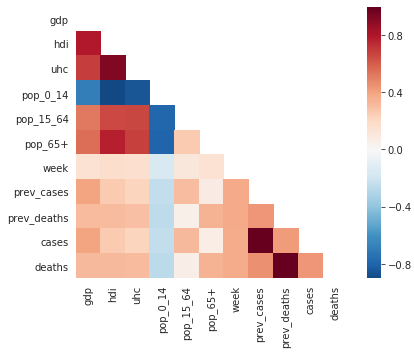

In [3]:
corr = df_final.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, center=0, cmap='RdBu_r', square=True)

# Treinamento

In [4]:
subject_countries = ['BRA','CHN','ESP','DEU','ITA','JPN','KOR','PRT','GBR','USA']

In [5]:
X = df_final[['gdp','hdi','uhc','pop_0_14','pop_15_64','pop_65+','week','prev_cases','prev_deaths']]
X.head()

,gdp,hdi,uhc,pop_0_14,pop_15_64,pop_65+,week,prev_cases,prev_deaths
0,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,1,0.000000,0.0
1,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,2,0.002629,0.0
2,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,3,0.010515,0.0
3,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,4,0.042059,0.0
4,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,5,0.089375,0.0


In [6]:
y = df_final[['cases','deaths']]
y.head()

,cases,deaths
0,0.002629,0.000000
1,0.010515,0.000000
2,0.042059,0.000000
3,0.089375,0.000000
4,0.299671,0.010515


In [7]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [8]:
random_state = 40
n_splits = 10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
kf = KFold(n_splits)

print('train: X', X_train.shape, '- y', y_train.shape, '- KFold splits', n_splits)
print(' test: X', X_test.shape, '- y', y_test.shape)

train: X (2560, 9) - y (2560, 2) - KFold splits 10
 test: X (641, 9) - y (641, 2)


In [9]:
def kfold_train_validate(modelo, kf, X, y):
    historico = []
    
    for k, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        modelo.fit(X.iloc[train_idx], y.iloc[train_idx])
        r2s = modelo.score(X.iloc[val_idx], y.iloc[val_idx])
        historico.append([k, r2s])
    
    historico = pd.DataFrame(data=historico, columns=['k','r2 score'])
    return historico

def describe(historico):
    return pd.DataFrame(historico['r2 score']).describe().transpose()

def plot(historico):
    sns.lineplot(x='k', y='r2 score', data=historico)
    plt.show()

In [10]:
def plot_true_vs_pred(countries):
    if len(countries) > 1:
        cols = 2
        rows = math.ceil(len(countries) / 2.0)
    else:
        cols = 1
        rows = 1
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15,7*rows))
    
    axx = 0; axy = 0
    
    if len(countries) % 2 == 1:
        axs[rows-1, 1].remove()
    
    for country in countries:
        df_plot = df_final[df_final['code'] == country].sort_values(by=['week'])
        X_plot = df_plot[['gdp','hdi','uhc','pop_0_14','pop_15_64','pop_65+','week','prev_cases','prev_deaths']]
        df_plot['pred'] = modelo.predict(X_plot)
        
        ax = axs[axx,axy]
        
        ax.set_title(df_plot.iloc[0]['country'])
        sns.scatterplot(x='week', y='cases', data=df_plot, ax=ax, color='b', label='True')
        sns.lineplot(x='week', y='pred', data=df_plot, ax=ax, color='r', label='Pred')
        ax.set_ylabel('cases')
        
        if axy == 1:
            axx = axx + 1
            axy = 0;
        else:
            axy = 1;
        
    plt.subplots_adjust(hspace=0.3)
    plt.show()

In [11]:
y_var = 'cases'
y_train = y_train[y_var]

### RFB com valores default
Segundo a documentação esse são os valores default dos hiper-parâmetros C e epsilon 

In [12]:
kernel = 'rbf'
gamma = 'scale'
C = 1.0
epsilon = 0.1

modelo = SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon)

In [13]:
historico = kfold_train_validate(modelo, kf, X_train, y_train)
describe(historico)

,count,mean,std,min,25%,50%,75%,max
r2 score,10.0,-0.013993,0.021473,-0.053347,-0.019945,-0.012915,-0.007397,0.025644


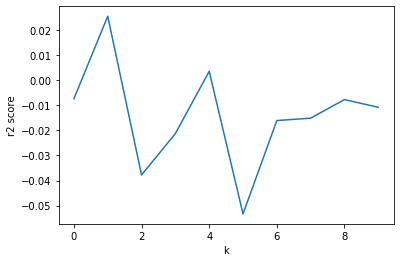

In [14]:
plot(historico)

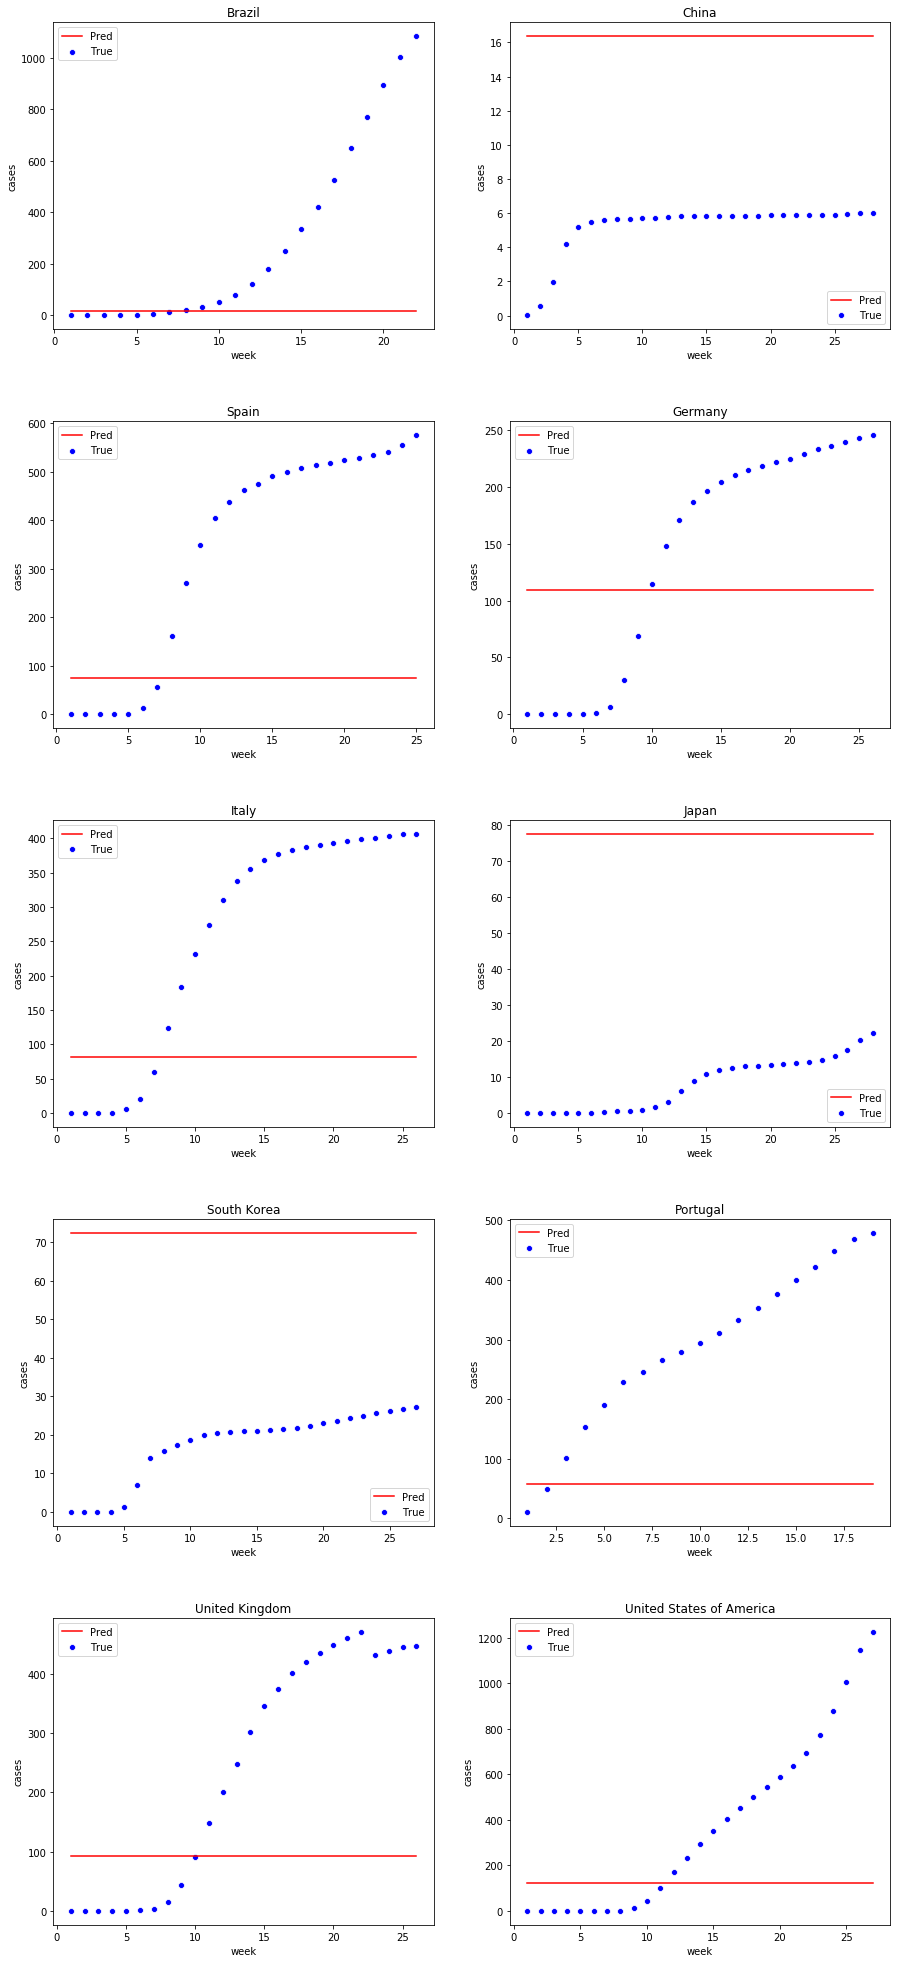

In [15]:
plot_true_vs_pred(subject_countries)

### StandardScaler

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [17]:
modelo = make_pipeline(StandardScaler(), SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon))

In [18]:
historico = kfold_train_validate(modelo, kf, X_train, y_train)
describe(historico)

,count,mean,std,min,25%,50%,75%,max
r2 score,10.0,0.14016,0.063095,0.050911,0.097454,0.122509,0.172474,0.252812


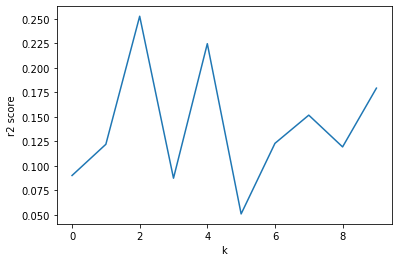

In [19]:
plot(historico)

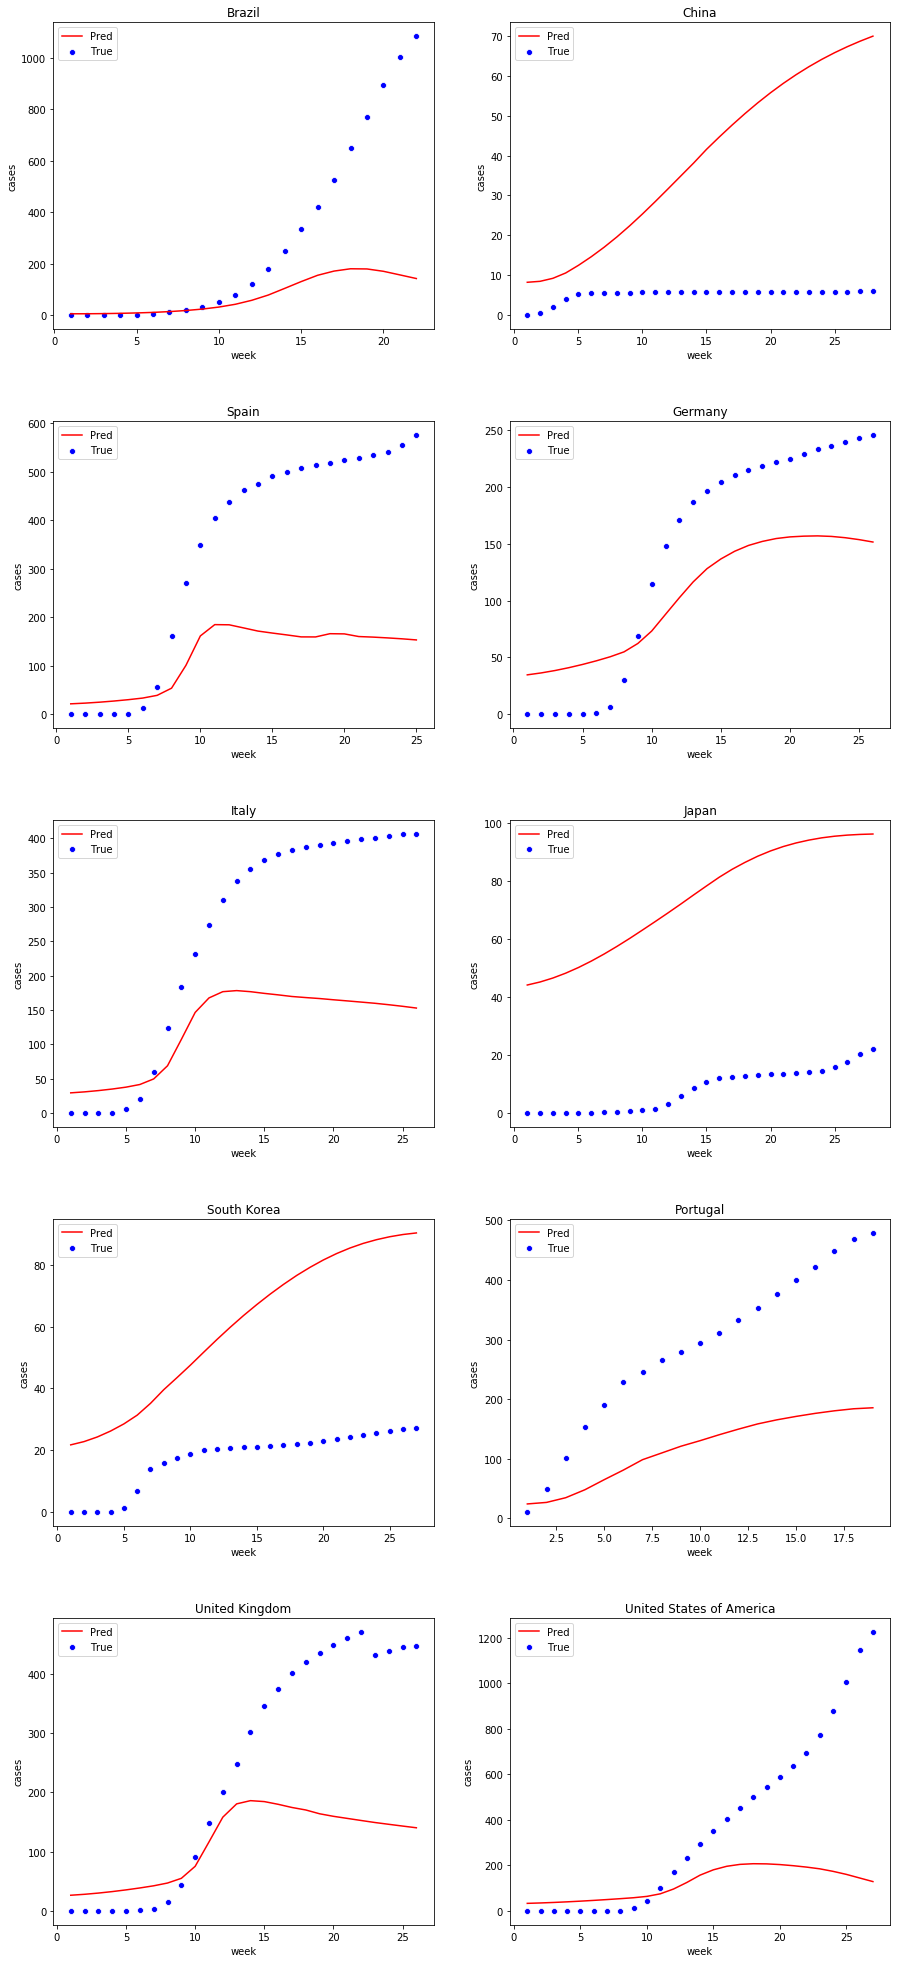

In [20]:
plot_true_vs_pred(subject_countries)

### Ajustes nos hiper-parâmetros

In [21]:
C = 100.0
epsilon = 0.1

modelo = make_pipeline(StandardScaler(), SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon))

In [22]:
historico = kfold_train_validate(modelo, kf, X_train, y_train)
describe(historico)

,count,mean,std,min,25%,50%,75%,max
r2 score,10.0,0.74156,0.198804,0.509163,0.582868,0.644284,0.960672,0.985257


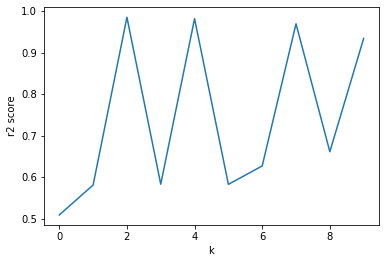

In [23]:
plot(historico)

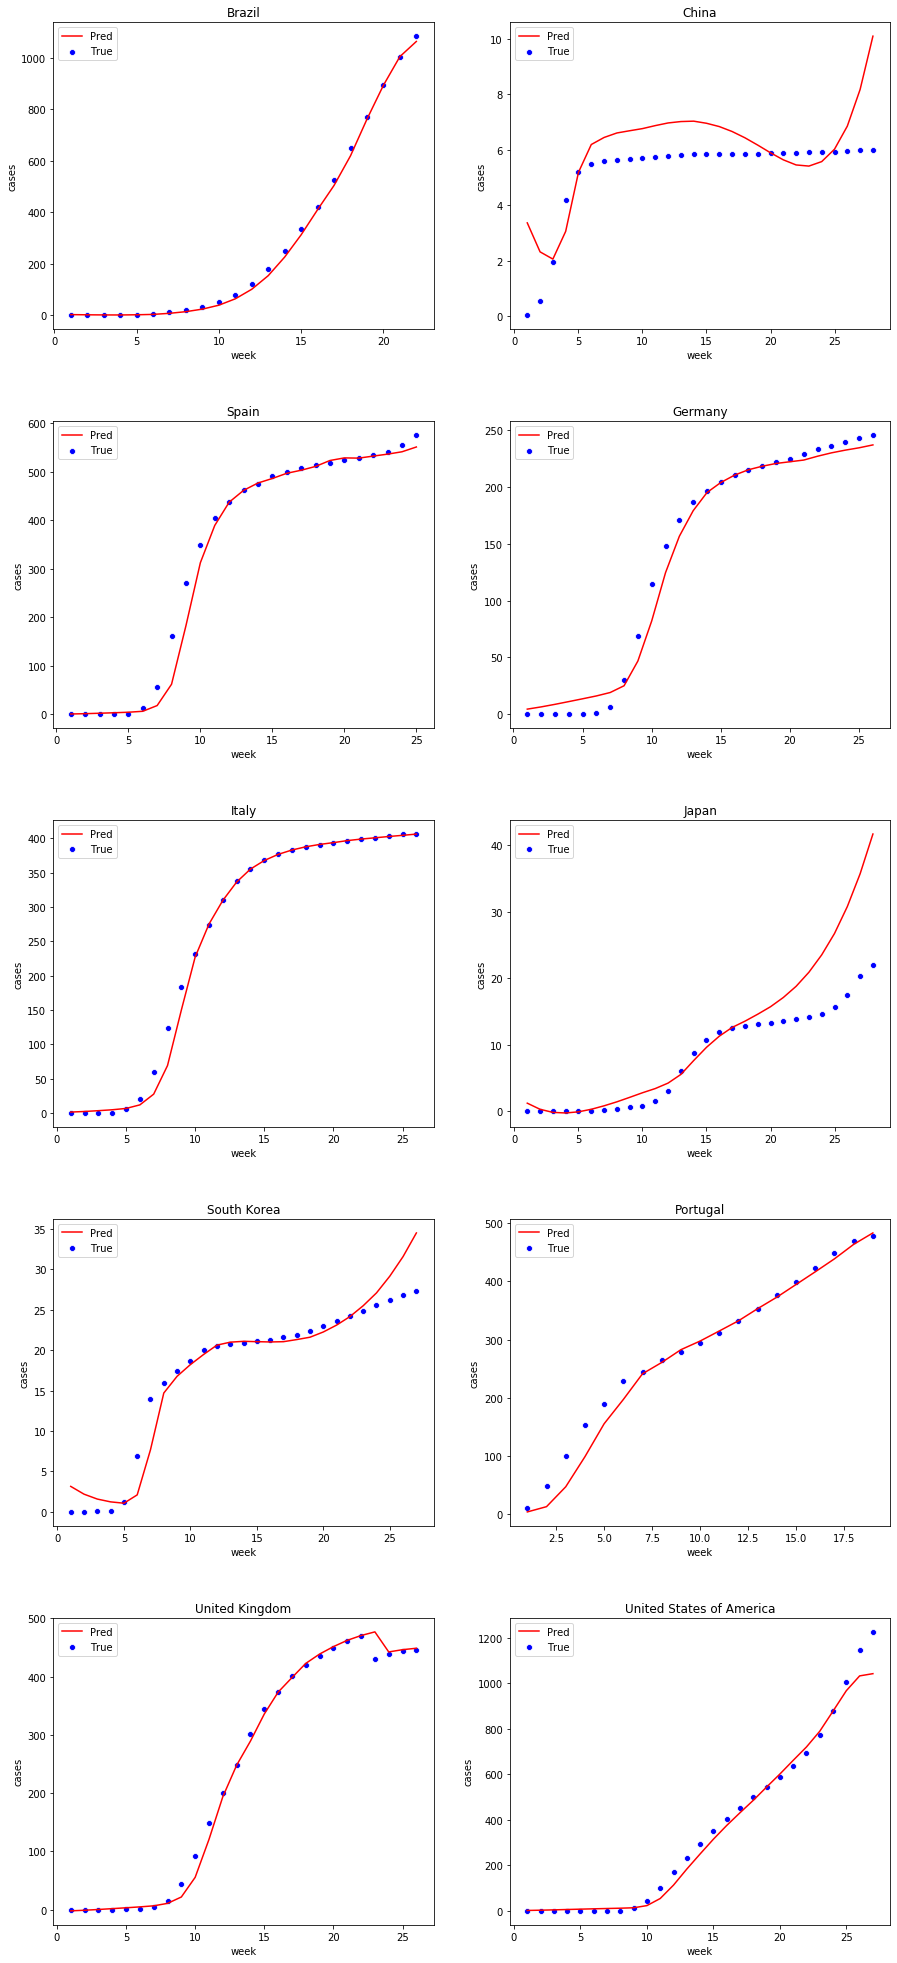

In [24]:
plot_true_vs_pred(subject_countries)

In [25]:
C = 1000.0
epsilon = 0.1

modelo = make_pipeline(StandardScaler(), SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon))

In [26]:
historico = kfold_train_validate(modelo, kf, X_train, y_train)
describe(historico)

,count,mean,std,min,25%,50%,75%,max
r2 score,10.0,0.98489,0.017239,0.95445,0.976012,0.994595,0.995804,0.997716


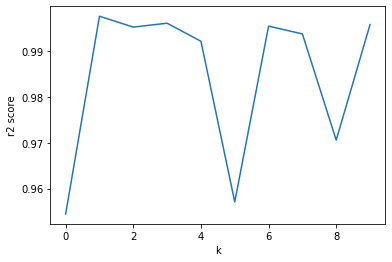

In [27]:
plot(historico)

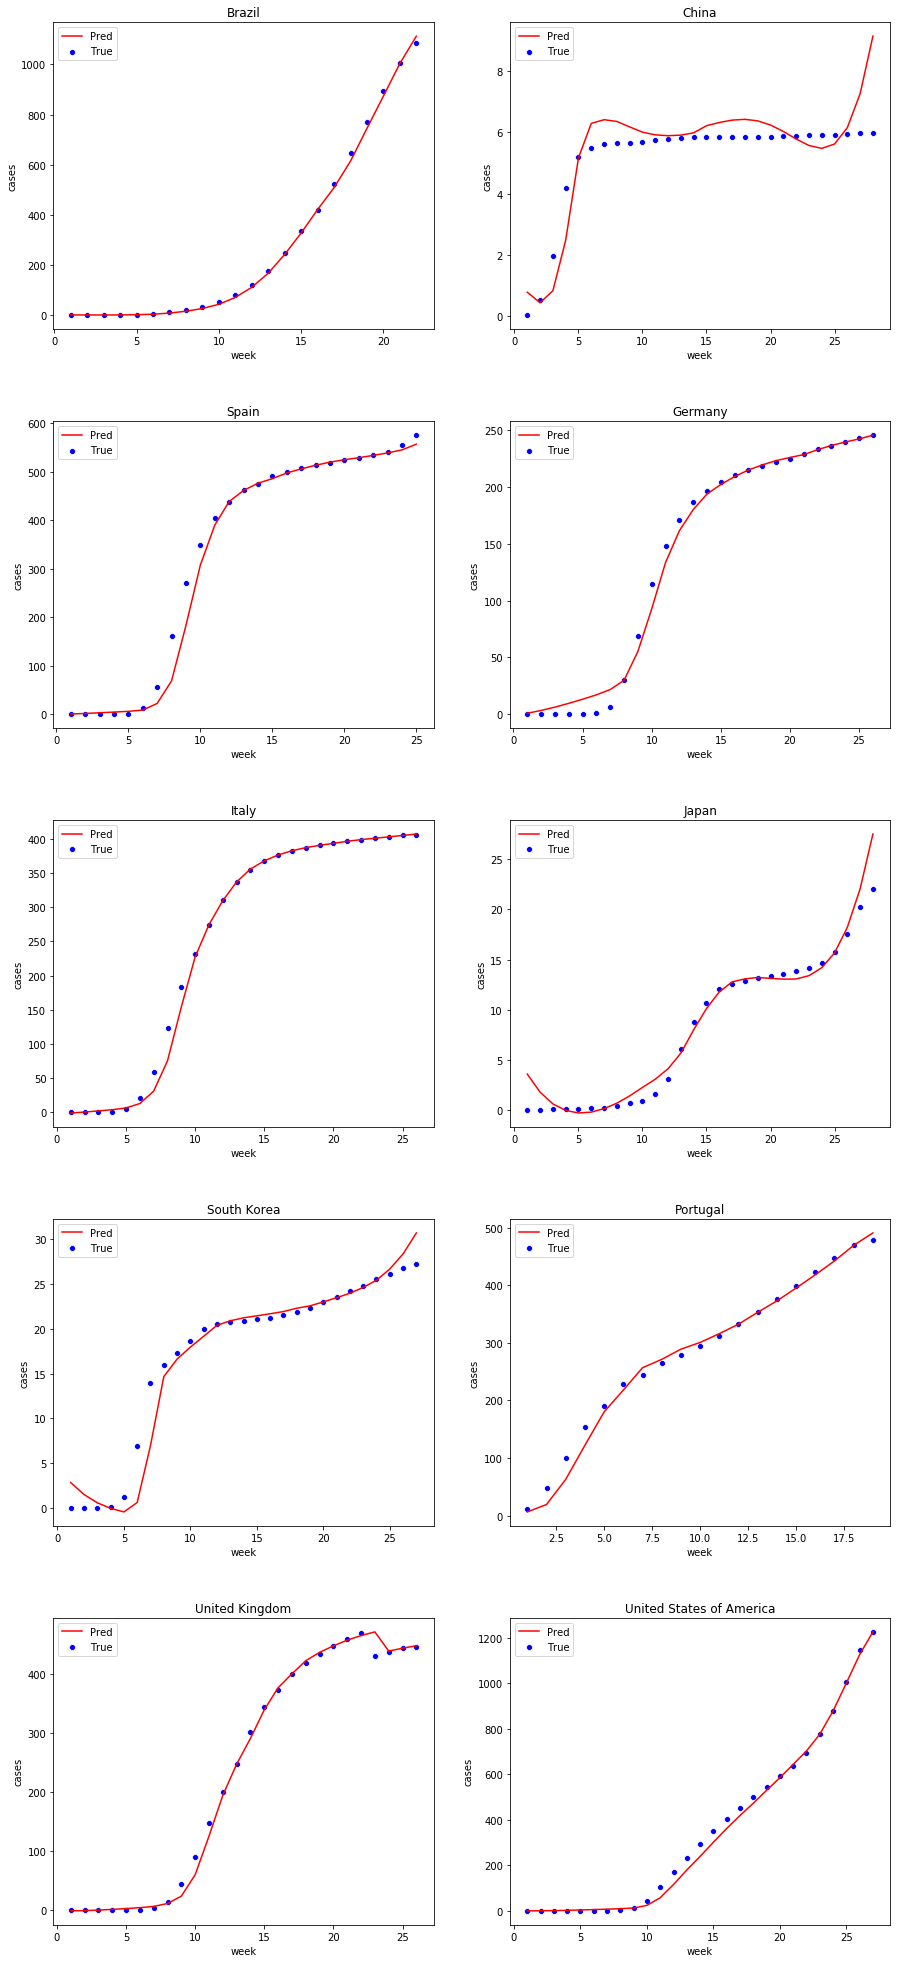

In [28]:
plot_true_vs_pred(subject_countries)

In [29]:
C = 2000.0
epsilon = 0.1

modelo = make_pipeline(StandardScaler(), SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon))

In [30]:
historico = kfold_train_validate(modelo, kf, X_train, y_train)
describe(historico)

,count,mean,std,min,25%,50%,75%,max
r2 score,10.0,0.992976,0.007178,0.97415,0.993048,0.99505,0.997122,0.99811


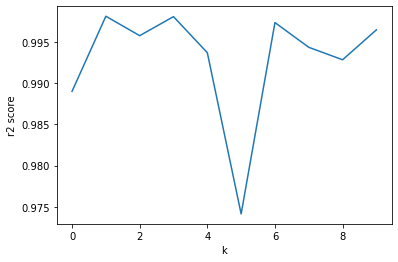

In [31]:
plot(historico)

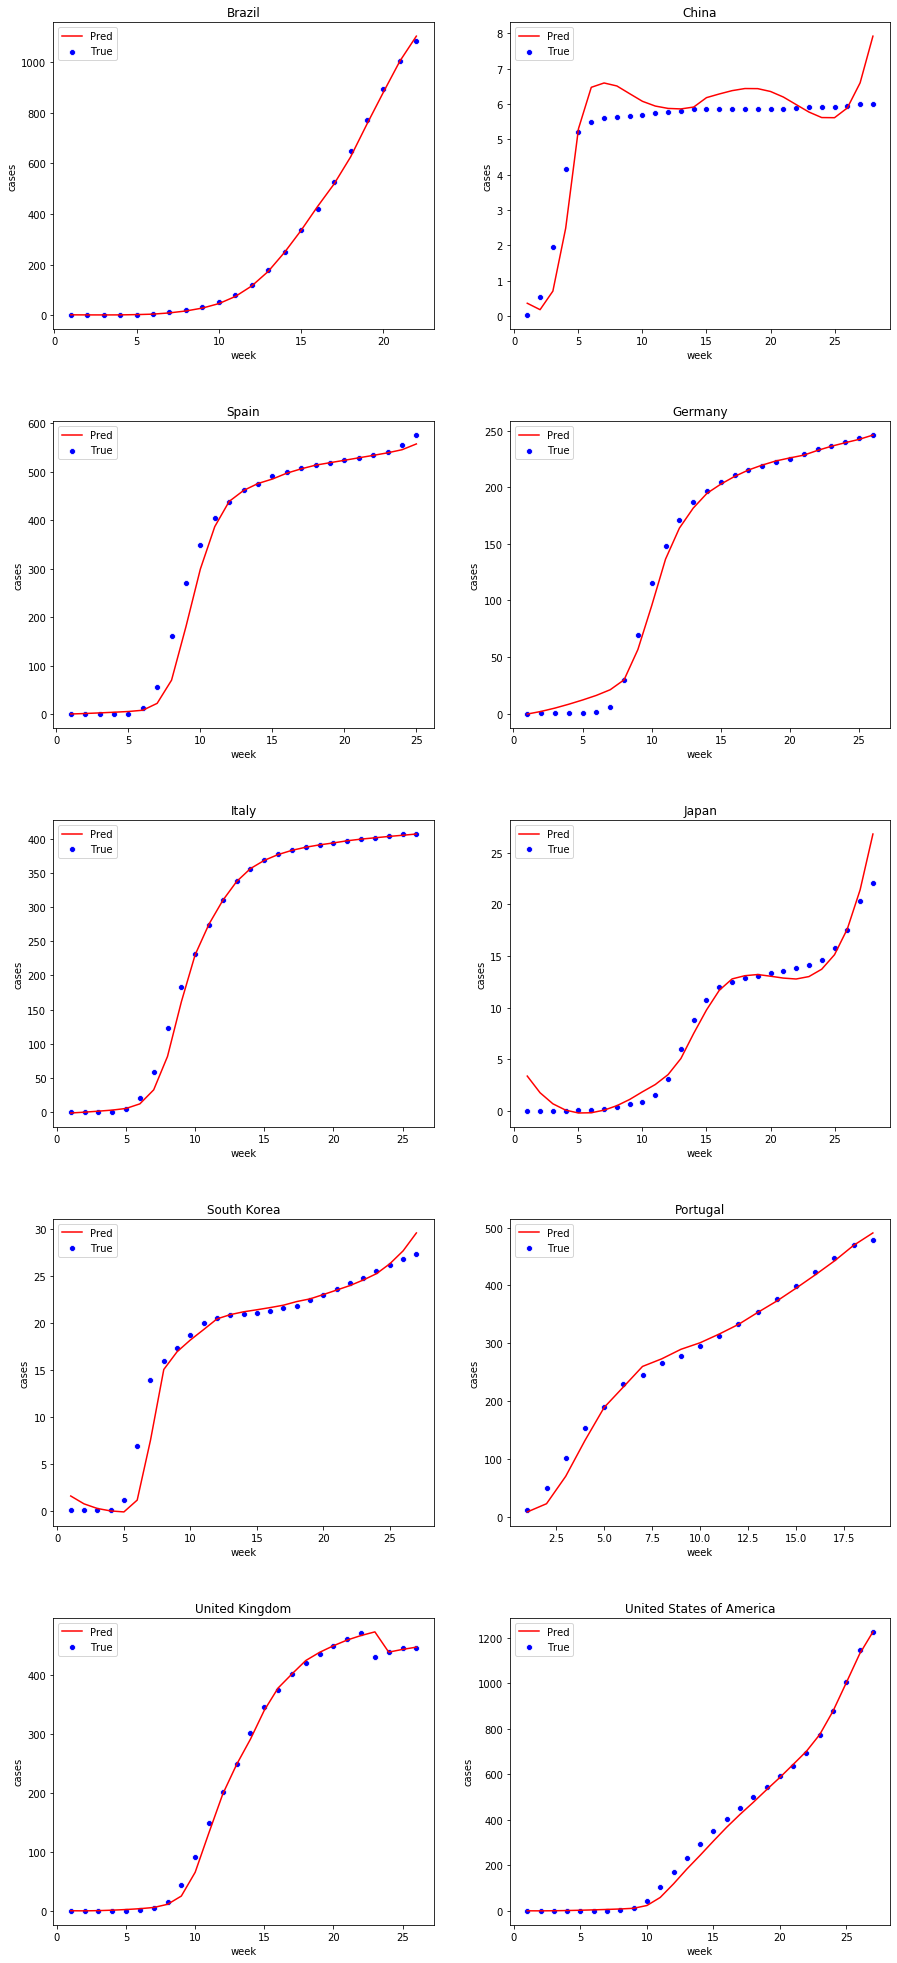

In [32]:
plot_true_vs_pred(subject_countries)

# Teste

In [33]:
r2s_test = modelo.score(X_test, y_test['cases'])
print("Test R2 score: {:3.6f}".format(r2s_test))

Test R2 score: 0.996533
